## Code To Generate Datasets using the Generated Images!

In [1]:
# Imports 
import os
from rembg import remove
import io
import random
import yaml
import os
from PIL import Image, ImageTk
import tkinter as tk
from helper_functions_image_creation import *
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import json
from datetime import datetime

In [2]:
import os

# Model
%env CUDA_VISIBLE_DEVICES=3,2
#%env PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:32

# HF Cache
os.environ["HF_HOME"] = "../.cache"
!echo $HF_HOME
!huggingface-cli whoami

env: CUDA_VISIBLE_DEVICES=3,2
../.cache


TorgeSchwark
orgs:  Basket-AEye


### Cut out Background of generated images and crop them

In [15]:
import os
import io
from PIL import Image
import matplotlib.pyplot as plt
from rembg import remove
from IPython.display import clear_output
from tqdm import tqdm


def find_all_png_files(root_dir):
    png_files = []
    for root, _, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith('.png'):
                full_path = os.path.join(root, file)
                png_files.append(full_path)
    return png_files


def process_image(input_path):
    try:
        with open(input_path, 'rb') as f:
            input_data = f.read()
        output_data = remove(input_data)
        output_image = Image.open(io.BytesIO(output_data)).convert("RGBA")
        bbox = output_image.getbbox()
        if bbox:
            output_image = output_image.crop(bbox)
        return output_image
    except Exception as e:
        print(f"⚠️ Fehler bei {input_path}: {e}")
        return None


def show_images_for_validation(images):
    clear_output(wait=True)
    print(f"📸 Zeige {len(images)} Bilder zur Bestätigung ...")

    num_cols = 5
    num_rows = (len(images) + num_cols - 1) // num_cols
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2.5, num_rows * 2.5))
    axs = axs.flatten()

    for ax in axs[len(images):]:
        ax.axis('off')

    for ax, img in zip(axs, images):
        black_bg = Image.new("RGBA", img.size, (0, 0, 0, 255))
        img_on_black = Image.alpha_composite(black_bg, img)
        ax.imshow(img_on_black.convert("RGB"))
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    while True:
        decision = input("[j] speichern, [n] verwerfen, [e] einzeln bearbeiten: ").strip().lower()
        if decision in ['j', 'n', 'e']:
            return decision


def remove_background_and_crop_cli(input_dir='../huggingface/ai_shelf/sd/10classes',
                                   output_dir='../huggingface/ai_shelf/sd/10classes_without_background',
                                   batch_size=5):
    os.makedirs(output_dir, exist_ok=True)
    images = {}

    # Schritt 1: Alle Bilder pro Klasse sammeln
    for subfolder in os.listdir(input_dir):
        subfolder_path = os.path.join(input_dir, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        images[subfolder] = find_all_png_files(subfolder_path)

    # Schritt 2: Alle Bilder verarbeiten und im Speicher halten
    processed_images = {}  # {klasse: [(img, pfad)]}
    print("🛠️ Verarbeite alle Bilder ...\n")
    for key in images:
        processed_images[key] = []
        for input_path in tqdm(images[key], desc=f"Verarbeite {key}", unit="Bild"):
            img = process_image(input_path)
            if img:
                # Relativen Pfad zum input_dir bestimmen
                rel_path = os.path.relpath(input_path, input_dir)
                # Alle Pfadtrenner durch Unterstriche ersetzen und Suffix anhängen
                safe_name = rel_path.replace(os.sep, '_').replace('.png', '_no_background.png')
                output_path = os.path.join(output_dir, key, safe_name)
                processed_images[key].append((img, output_path))

    # Schritt 3: Alle Bilder klassenweise in Batches anzeigen & validieren
    for key in processed_images:
        print(f"\n🔍 Validierung für Klasse: {key} ({len(processed_images[key])} Bilder)")
        class_output_dir = os.path.join(output_dir, key)
        os.makedirs(class_output_dir, exist_ok=True)

        for i in range(0, len(processed_images[key]), batch_size):
            batch = processed_images[key][i:i + batch_size]
            batch_images = [img for img, _ in batch]
            batch_paths = [path for _, path in batch]

            decision = show_images_for_validation(batch_images)

            if decision == 'j':
                for img, out_path in zip(batch_images, batch_paths):
                    img.save(out_path)
                    print(f"✔️ Gespeichert: {out_path}")
            elif decision == 'n':
                print("⛔️ Bilder verworfen.")
            elif decision == 'e':
                print("⚠️ Einzelbild-Validierung gestartet ...")
                for img, out_path in zip(batch_images, batch_paths):
                    clear_output(wait=True)
                    black_bg = Image.new("RGBA", img.size, (0, 0, 0, 255))
                    img_on_black = Image.alpha_composite(black_bg, img)

                    plt.figure(figsize=(3, 3))
                    plt.imshow(img_on_black.convert("RGB"))
                    plt.axis('off')
                    plt.tight_layout()
                    plt.show()

                    while True:
                        single_decision = input("[j] speichern, [n] verwerfen, [e] nächstes Bild: ").strip().lower()
                        if single_decision in ['j', 'n', 'e']:
                            break

                    if single_decision == 'j':
                        img.save(out_path)
                        print(f"✔️ Gespeichert: {out_path}")
                    elif single_decision == 'n':
                        print("⛔️ Verworfen.")
                    elif single_decision == 'e':
                        print("⏭️ Weiter zum nächsten Bild.")

    print("\n✅ Alle Bilder verarbeitet und validiert.")


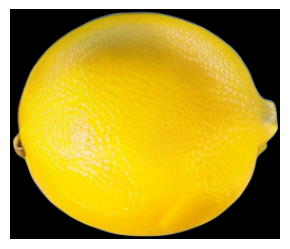

✔️ Gespeichert: ../huggingface/ai_shelf/sd/10classes_without_background/lemon/lemon_lemon13_top_3_no_background.png

✅ Alle Bilder verarbeitet und validiert.


In [16]:
remove_background_and_crop_cli()

## Flatten all subfolders for Mats weired stucture

In [12]:
import os
import shutil

def flatten_subfolders(parent_dir):
    # Durchlaufe alle direkten Unterordner im parent_dir (z. B. 10classes/äpfel/)
    for category in os.listdir(parent_dir):
        category_path = os.path.join(parent_dir, category)
        if not os.path.isdir(category_path):
            continue

        print(f"🔍 Bearbeite Kategorie: {category}")
        for dirpath, dirnames, filenames in os.walk(category_path, topdown=False):
            for filename in filenames:
                rel_path = os.path.relpath(dirpath, category_path)
                if rel_path == ".":
                    continue  # Datei liegt schon in der Kategorie

                parts = rel_path.split(os.sep)
                prefix = "_".join(parts)
                new_name = f"{prefix}_{filename}"

                source_path = os.path.join(dirpath, filename)
                dest_path = os.path.join(category_path, new_name)

                # Namenskonflikte vermeiden
                if os.path.exists(dest_path):
                    base, ext = os.path.splitext(new_name)
                    counter = 1
                    while os.path.exists(dest_path):
                        new_name = f"{base}_{counter}{ext}"
                        dest_path = os.path.join(category_path, new_name)
                        counter += 1

                print(f"   📦 Verschiebe: {source_path} → {dest_path}")
                shutil.move(source_path, dest_path)

            # Leere Unterordner löschen
            if dirpath != category_path:
                try:
                    os.rmdir(dirpath)
                    print(f"   🗑️ Lösche Unterordner: {dirpath}")
                except OSError:
                    print(f"   ⛔ Nicht-leerer Ordner: {dirpath}")

ordner = "../huggingface/ai_shelf/sd/10classes"
if os.path.isdir(ordner):
    flatten_subfolders(ordner)
    print("✅ Alle Kategorien fertig bearbeitet.")
else:
    print("❌ Ungültiger Pfad.")


🔍 Bearbeite Kategorie: banana
   📦 Verschiebe: ../huggingface/ai_shelf/sd/10classes/banana/banana1/sides/0.png → ../huggingface/ai_shelf/sd/10classes/banana/banana1_sides_0.png
   📦 Verschiebe: ../huggingface/ai_shelf/sd/10classes/banana/banana1/sides/1.png → ../huggingface/ai_shelf/sd/10classes/banana/banana1_sides_1.png
   📦 Verschiebe: ../huggingface/ai_shelf/sd/10classes/banana/banana1/sides/2.png → ../huggingface/ai_shelf/sd/10classes/banana/banana1_sides_2.png
   📦 Verschiebe: ../huggingface/ai_shelf/sd/10classes/banana/banana1/sides/3.png → ../huggingface/ai_shelf/sd/10classes/banana/banana1_sides_3.png
   📦 Verschiebe: ../huggingface/ai_shelf/sd/10classes/banana/banana1/sides/4.png → ../huggingface/ai_shelf/sd/10classes/banana/banana1_sides_4.png
   📦 Verschiebe: ../huggingface/ai_shelf/sd/10classes/banana/banana1/sides/5.png → ../huggingface/ai_shelf/sd/10classes/banana/banana1_sides_5.png
   📦 Verschiebe: ../huggingface/ai_shelf/sd/10classes/banana/banana1/sides/6.png → ../hu

In [3]:
def load_images(object_folders, background_folder, ratio=[60, 30, 10]):
    """
    Load and split images into training, validation, and test sets based on the given ratio.
    Returns object_dict, background_dict, and category_to_id (mapping category name -> int ID).
    """
    objects_dict = {}
    backgrounds = []

    # Load scale mapping from central scale.txt
    scale_path = os.path.join(object_folders, "scale.txt")
    if os.path.exists(scale_path):
        try:
            with open(scale_path, "r") as f:
                scale_mapping = json.load(f)  # expects JSON format
        except Exception as e:
            print(f"Error reading scale.txt: {e}")
            scale_mapping = {}
    else:
        print("Warning: No central scale.txt found. Using default scale = 1.0 for all categories.")
        scale_mapping = {}

    # Load object images and scale per category
    for subfolder in os.listdir(object_folders):
        subfolder_path = os.path.join(object_folders, subfolder)

        if os.path.isdir(subfolder_path):
            object_files = [f for f in os.listdir(subfolder_path) if f.endswith('.png')]
            random.shuffle(object_files)

            scale_value = scale_mapping.get(subfolder, 1.0)

            objects_dict[subfolder] = {
                "files": object_files,
                "scale": scale_value
            }

    # Load background images
    for f in os.listdir(background_folder):
        if f.endswith('.png'):
            backgrounds.append(os.path.join(background_folder, f))

    random.shuffle(backgrounds)

    # Split background images
    train_bg = backgrounds[:int(len(backgrounds) * ratio[0] / 100)]
    val_bg = backgrounds[int(len(backgrounds) * ratio[0] / 100):int(len(backgrounds) * (ratio[0] + ratio[1]) / 100)]
    test_bg = backgrounds[int(len(backgrounds) * (ratio[0] + ratio[1]) / 100):]

    # Split object images into dictionaries for each set
    def split_objects(objects_dict):
        split = {"train": {}, "val": {}, "test": {}}
        for category, data in objects_dict.items():
            files = data["files"]
            scale = data["scale"]

            train_size = int(len(files) * ratio[0] / 100)
            val_size = int(len(files) * ratio[1] / 100)

            split["train"][category] = {"files": files[:train_size], "scale": scale}
            split["val"][category] = {"files": files[train_size:train_size + val_size], "scale": scale}
            split["test"][category] = {"files": files[train_size + val_size:], "scale": scale}
        return split

    object_dict = split_objects(objects_dict)

    # Create category-to-ID mapping
    category_to_id = {category: idx for idx, category in enumerate(sorted(objects_dict.keys()))}

    print("Done loading and splitting images.")
    backgrounds_dict = {"train": train_bg, "val": val_bg, "test": test_bg}
    
    return object_dict, backgrounds_dict, category_to_id



def generate_images_and_labels(objects_dict, backgrounds, objects_folder, output_folder, output_labels, category_to_id, count=1000):
    """
    Generate images using a specific set of objects and backgrounds.
    objects_dict has format: {category: {"files": [...], "scale": float}}
    """
    os.makedirs(output_folder, exist_ok=True)
    os.makedirs(output_labels, exist_ok=True)

    i = 0
    while i < count:
        # Select a random background
        background_image = Image.open(random.choice(backgrounds)).convert("RGBA")
        
        num_objects = random.randint(1, 15)
        selected_objects = []
        object_counts = {key: 0 for key in objects_dict.keys()}

        for _ in range(num_objects):
            category = random.choice(list(objects_dict.keys()))
            file = random.choice(objects_dict[category]["files"])
            scale = objects_dict[category]["scale"]

            path = os.path.join(objects_folder, category, file)
            image = Image.open(path).convert("RGBA")
            image.info["custom_scale"] = scale  # Übergib scale an späteren Code
            selected_objects.append((image, category))

        # Place the objects on the background
        result, yolo_labels = place_objects_on_background(background_image, selected_objects, object_counts, category_to_id)

        if result is False and yolo_labels is False:
            print(f"[{i+1}/{count}] Kein Objekt konnte platziert werden, wiederhole...")
            continue  # Wiederhole Iteration ohne i zu erhöhen

        # Save the generated image
        image_filename = f'generated_image_{i+1}.png'
        result.save(os.path.join(output_folder, image_filename))

        # Save YOLO labels
        label_filename = image_filename.replace(".png", ".txt")
        label_path = os.path.join(output_labels, label_filename)
        with open(label_path, "w") as f:
            for label in yolo_labels:
                f.write(label + "\n")

        print(f"[{i+1}/{count}] Bild gespeichert: {image_filename}")
        i += 1  # Nur erhöhen, wenn erfolgreich

        
def create_yaml_for_generated(output_folders, category_to_id, output_dir):
    """
    Create a dataset.yaml file for the generated dataset.

    Args:
        output_folders (dict): Dictionary with keys 'train', 'val', 'test', and their corresponding folder paths.
        category_to_id (dict): Mapping from category name to unique integer ID.
        output_dir (str): Directory where the dataset.yaml file should be saved.
    """
    os.makedirs(output_dir, exist_ok=True)

    # Build the YAML data
    yaml_data = {
        "train": os.path.relpath(output_folders["train"], output_dir),
        "val": os.path.relpath(output_folders["val"], output_dir),
        "nc": len(category_to_id),
        "names": {v: k for k, v in sorted(category_to_id.items(), key=lambda x: x[1])}
    }

    # Write YAML to file
    yaml_path = os.path.join(output_dir, "dataset.yaml")
    with open(yaml_path, 'w') as yaml_file:
        yaml.dump(yaml_data, yaml_file, sort_keys=False)

    print(f"dataset.yaml created at: {yaml_path}")


In [5]:
import sys
sys.path.append("/data22/stu236894/GitRepos/TinyML-MT/code_imagegeneration/models/external/cyclegan/models")

In [ ]:
# Main folder containing the objects
objects_folders = '../huggingface/ai_shelf/sd/10classes_without_background'
background_folder = '../huggingface/ai_shelf/sd/background'

objects_dicts, backgrounds_dict, category_to_id = load_images(objects_folders, background_folder)

output_folder_lable = {"train": "../huggingface/ai_shelf/artificial_mult_back_10_class/labels/train", "val": "../huggingface/ai_shelf/artificial_mult_back_10_class/labels/val", "test":"../huggingface/ai_shelf/artificial_mult_back_10_class/labels/test"}
output_folders = {"train": "../huggingface/ai_shelf/artificial_mult_back_10_class/images/train", "val": "../huggingface/ai_shelf/artificial_mult_back_10_class/images/val", "test": "../huggingface/ai_shelf/artificial_mult_back_10_class/images/test"}


generate_images_and_labels(objects_dicts["train"], backgrounds_dict["train"], objects_folders, output_folders["train"], output_folder_lable["train"],  category_to_id, count=1)

Done loading and splitting images.


TypeError: generate_images_and_labels() got an unexpected keyword argument 'show'

In [ ]:
# Main folder containing the objects
objects_folders = '../huggingface/ai_shelf/sd/second_without_background'
background_folder = '../huggingface/ai_shelf/sd/background'

objects_dicts, backgrounds_dict, category_to_id = load_images(objects_folders, background_folder)

output_folder_lable = {"train": "../huggingface/ai_shelf/artificial_mult_back/labels/train", "val": "../huggingface/ai_shelf/artificial_mult_back/labels/val", "test":"../huggingface/ai_shelf/artificial_mult_back/labels/test"}
output_folders = {"train": "../huggingface/ai_shelf/artificial_mult_back/images/train", "val": "../huggingface/ai_shelf/artificial_mult_back/images/val", "test": "../huggingface/ai_shelf/artificial_mult_back/images/test"}


generate_images_and_labels(objects_dicts["train"], backgrounds_dict["train"], objects_folders, output_folders["train"],output_folder_lable["train"],  category_to_id, count=1000)
generate_images_and_labels(objects_dicts["val"], backgrounds_dict["val"], objects_folders, output_folders["val"], output_folder_lable["val"], category_to_id, count=300)
generate_images_and_labels(objects_dicts["test"], backgrounds_dict["test"], objects_folders, output_folders["test"],output_folder_lable["test"], category_to_id, count=100)
create_yaml_for_generated(output_folders, category_to_id, "../huggingface/ai_shelf/artificial_mult_back")

Done loading and splitting images.
shape: 100 100
shape: 100 100
shape: 100 100
shape: 100 100
shape: 100 100
shape: 100 100
shape: 100 100
shape: 100 100
shape: 100 100
shape: 100 100
Keine freien Zellen mehr verfügbar nach padding.
[1/1000] Bild gespeichert: generated_image_1.png
shape: 100 100
[2/1000] Bild gespeichert: generated_image_2.png
shape: 100 100
shape: 100 100
shape: 100 100
shape: 100 100
shape: 100 100
shape: 100 100
shape: 100 100
shape: 100 100
shape: 100 100
shape: 100 100
shape: 100 100
shape: 100 100
shape: 100 100
Keine freien Zellen mehr verfügbar nach padding.
[3/1000] Bild gespeichert: generated_image_3.png
shape: 100 100
shape: 100 100
shape: 100 100
shape: 100 100
shape: 100 100
shape: 100 100
shape: 100 100
shape: 100 100
shape: 100 100
shape: 100 100
shape: 100 100
[4/1000] Bild gespeichert: generated_image_4.png
shape: 100 100
shape: 100 100
shape: 100 100
shape: 100 100
shape: 100 100
shape: 100 100
shape: 100 100
shape: 100 100
shape: 100 100
shape: 100 

KeyboardInterrupt: 